In [44]:
from tools import *
from odes import *
from ValueTable import *

In [45]:
path = r'C:\Users\Abraham\OneDrive - Universitetet i Agder\Desktop\AndreasPrinz\temperature_data.csv'
value_table = autofill_and_initiate_value_table(csv_path=path, value_table=ValueTable(unit=TimeUnits.hour))

In [46]:
class Envo(ODE):
    def __init__(self, notation):
        super().__init__(notation=notation)
        self.state = value_table.currentTemp

    @classmethod
    def compute_temp(cls, t):
        #return 5 * np.sin(2 * np.pi * (t/3600 - 10)/24) + 10
        return value_table.linear(t)

    def dy_dt(self, t):
        vt = self.compute_temp(t=t)
        self.rate = self.state - vt
        self.rate = (value_table.nextTemp - vt)/(value_table.nextTime - value_table.currentTime)
        return self.rate

In [47]:
class Room(ODE):
    def __init__(self, notation):
        super().__init__(notation=notation)
        self.state = TEMP_NIGHT_NOMINAL
        self.open = False

    def dy_dt2(self, t):
        radiator_power = K_RADIATOR * A_RADIATOR * (radiator.state - self.state)
        wall_loss_rate = A_WALL * K_WALL * (self.state - env.state)
        window_loss_rate = A_WINDOW * {False: U.wi_closed, True: U.wi_open}[self.open] * (self.state - env.state)
        self.rate = (radiator_power - window_loss_rate - wall_loss_rate) / (C_AIR * D_AIR * V_ROOM)
        return self.rate

    def dy_dt3(self, t):
        q_wi = (self.state - env.state) * A_WINDOW * {False: U.wi_closed, True: U.wi_open}[self.open]  # windows loss rate
        q_wa = (self.state - env.state) * A_ROOF * U.wa
        q_ro = (self.state - env.state) * A_ROOF * U.ro
        self.dq = radiator.dq - q_wi - q_wa - q_ro
        self.rate = self.dq / (C_AIR * D_AIR * V_ROOM)
        return self.rate

    def dy_dt(self, t):
        print('radiator state', radiator.state)
        radiator_power = K_RADIATOR * A_RADIATOR * (radiator.state - self.state)
        wall_loss_rate = A_WALL * K_WALL * (self.state - env.state)
        window_loss_rate = A_WINDOW * {False: U.wi_closed, True: U.wi_open}[self.open] * (self.state - env.state)
        self.rate = (radiator_power - window_loss_rate - wall_loss_rate) / (C_AIR * D_AIR * V_ROOM)
        R2.set_state(self.rate)
        return self.rate

In [48]:
class Radiator(ODE):
    def __init__(self, notation, hyst = 1):
        super().__init__(notation=notation)
        self.on: bool = False
        self.state = TEMP_NIGHT_NOMINAL
        self.tempNominal = TEMP_NIGHT_NOMINAL
        self.hyst = hyst
        self.temp_diff = 0

    def dy_dt(self, t):
        opening = self.opening()
        self.dq = (self.state - room.state) * A_RADIATOR * U.he
        dt_gain = opening * F_WATER * (boiler.state - self.state) / V_RADIATOR
        dt_loss = self.dq / (D_AIR * C_WATER * V_RADIATOR)
        self.rate = dt_gain - dt_loss
        R1.set_state(self.rate)
        return self.rate

    def opening(self):
        self.temp_diff =  self.tempNominal - room.state
        if self.temp_diff <= 0:
            res = 0

        elif self.temp_diff >= self.hyst:
            res = 1

        else:
            res = self.temp_diff/self.hyst

        opening.set_state(res)
        return res

In [49]:
class WaterRadiator(Radiator):
    def __init__(self, notation, init_temp, init_hyst):
        super().__init__(notation=notation, hyst=init_hyst)
        self.hyst = init_hyst
        self.state = init_temp


    def dy_dt(self, t):
        temp_in = boiler.state
        opening = self.opening()
        T1 = opening * (F_WATER / V_RADIATOR_WATER) * (temp_in - self.state)
        T2 = K_RADIATOR * A_RADIATOR * (room.state - self.state)/(V_RADIATOR_WATER * D_WATER * C_WATER)
        self.rate = T1 + T2
        return self.rate

In [50]:
class Opening(ODE):
    def __init__(self, notation):
        super().__init__(notation=notation)

    def dy_dt(self, t):
        self.rate = 0
        return 0

    def set_state(self, state):
        self.state = state

In [51]:
class Rate(ODE):
    def __init__(self, notation):
        super().__init__(notation=notation)

    def dy_dt(self, t):
        self.rate = 0
        return 0

    def set_state(self, state):
        self.state = state

In [52]:
main_event = Event(name='main_event', time=8**8, repeat=5 * TimeUnits.minute)
per_minute = Event(name='pm_event', time=2**2, repeat=TimeUnits.second)
per_3_minute = Event(name='pm_event', time=3**3, repeat=3*TimeUnits.minute)
per_5_minute = Event(name='pm_event', time=4**4, repeat=5 * TimeUnits.minute)
per_10_minute = Event(name='pm_event', time=5**5, repeat=10 * TimeUnits.minute)
per_quarter = Event(name='pm_event', time=6**6, repeat=15 * TimeUnits.minute)
per_hour = Event(name='ph_event', time=7**7, repeat=TimeUnits.hour)

#### Calendar

In [53]:
wake_up = Event(name='wake_up', time=7 * TimeUnits.hour + 2, repeat=24 * TimeUnits.hour)
time_to_sleep = Event(name='time_to_sleep', time=22 * TimeUnits.hour + 123, repeat=24 * TimeUnits.hour)

In [54]:
open_window = Event(name='open_window', time=7.10 * TimeUnits.hour)
close_window = Event(name='close_window', time=10 * TimeUnits.hour)

In [55]:
ow1 = Event(name='open_window', time=10.503 * TimeUnits.hour)
cw1 = Event(name='close_window', time=11.032 * TimeUnits.hour)

ow2 = Event(name='open_window', time=14.045 * TimeUnits.hour)
cw2 = Event(name='close_window', time=14.559 * TimeUnits.hour)

ow3 = Event(name='open_window', time=17.0234 * TimeUnits.hour)
cw3 = Event(name='close_window', time=17.5422 * TimeUnits.hour)

ow7 = Event(name='open_window', time=(18.0234 + 1) * TimeUnits.hour)
cw7 = Event(name='close_window', time=(18.5422 + 1) * TimeUnits.hour)

ow4 = Event(name='open_window', time=20.0543 * TimeUnits.hour)
cw4 = Event(name='close_window', time=21.9012 * TimeUnits.hour)

ow5 = Event(name='open_window', time=22.3002 * TimeUnits.hour)
cw5 = Event(name='close_window', time=23.05 * TimeUnits.hour)

cw_ow_events = [
    ow1, ow2, ow3, ow4,  ow5, cw1, cw2, cw3, cw4,  cw5, cw7, ow7
]

In [56]:
def update_integrator(ode, **kwargs):
    kwargs['ics'][ode.notation] = ode.state
    kwargs['params'][f'{ode.notation}_rate'] = ode.rate

In [57]:
def update_rate(ode, **kwargs):
    ode.state = kwargs['c_step']['points'][ode.notation][-1]
    ode.dy_dt(t=kwargs['t'][-1])

In [58]:
def clb_env_temp(**kwargs):
    env.state = env.compute_temp(t=kwargs['t'][-1])
    env.dy_dt(t=kwargs['t'][-1])
    print('rate env', env.rate)
    #update_rate(ode=radiator, **kwargs)
    update_integrator(ode=env, **kwargs)

In [59]:
def clb_room_temp(**kwargs):
    update_rate(ode=room, **kwargs)
    update_integrator(ode=room, **kwargs)

In [60]:
def clb_radiator_temp(**kwargs):
    update_rate(ode=radiator, **kwargs)
    update_integrator(ode=radiator, **kwargs)
    update_integrator(ode=opening, **kwargs)
    # print(radiator.state)
    pass

In [61]:
def clb_wake_up(**kwargs):
    radiator.tempNominal = TEMP_DAY_NOMINAL
    kwargs['c_step']['points'][radiator.notation][-1] = TEMP_DAY_NOMINAL
    # radiator.dy_dt(t=kwargs['t'][-1])
    update_integrator(ode=radiator, **kwargs)
    print(f'Waking up')

In [62]:
def clb_sleep(**kwargs):
    radiator.tempNominal = TEMP_NIGHT_NOMINAL
    # radiator.dy_dt(t=kwargs['t'][-1])
    update_integrator(ode=radiator, **kwargs)

In [63]:
def clb_toggle_window(**kwargs):
    room.open = not room.open

In [64]:
def clb_open_window(**kwargs):
    room.open = True

In [65]:
def clb_close_window(**kwargs):
    room.open = False

In [66]:
def clb_log_callback(**kwargs):
    info = lambda ode: {'state': ode.state, 'rate': ode.rate}
    time_ = kwargs['c_step']['points']['t'][-1]
    information = {
        'room': {**info(room), 'open': room.open},
        'radiator': {**info(radiator), 'opening': radiator.opening(), 'diff': radiator.temp_diff},
    }
    print([time_/3600, time_, integrator.tdata[-1]])
    print(information, '\n')

In [67]:
for e in cw_ow_events:
    if 'open' in e.name:
        e.attach_callback(clb_open_window)
    else:
        e.attach_callback(clb_close_window)

In [68]:
main_event.attach_callback(func=clb_env_temp)
main_event.attach_callback(func=clb_log_callback)
main_event.attach_callback(func=clb_room_temp)
main_event.attach_callback(func=clb_radiator_temp)
wake_up.attach_callback(func=clb_wake_up)
time_to_sleep.attach_callback(func=clb_sleep)

In [69]:
TEMP_NIGHT_NOMINAL = 15
TEMP_DAY_NOMINAL = 22
BOILER_WATER_TEMP = 40
EXPERIMENT_DURATION = TimeUnits.day

In [70]:
room = Room(notation='room')
env = Envo(notation='env')
boiler = Boiler(notation='boiler')
radiator = WaterRadiator(notation='radiator', init_temp=TEMP_NIGHT_NOMINAL, init_hyst=1)
opening = Opening(notation='opening')
radiator.state = TEMP_NIGHT_NOMINAL
room.state = TEMP_NIGHT_NOMINAL
opening.set_state(state=radiator.opening())
R1 = Rate('R1')
R1.set_state(radiator.dy_dt(0))
R2 = Rate('R2')
R2.set_state(room.dy_dt(0))

radiator state 15


## Instantiate the integrator

In [71]:
integrator = Integrator(
    expressions={**env.expr, **boiler.expr, **radiator.expr, **room.expr, **opening.expr,**R1.expr,**R2.expr},
    ics={**env.ics, **boiler.ics, **radiator.ics, **room.ics, **opening.ics, **R1.ics, **R2.ics},
    events=[
        wake_up,
        time_to_sleep,
        main_event,
        *cw_ow_events
    ],
    tdata=[0, TimeUnits.day],
    params={
        'env_rate': env.dy_dt(t=0),
        'boiler_rate': boiler.dy_dt(t=0),
        'radiator_rate': radiator.dy_dt(t=0),
        'room_rate': room.dy_dt(t=0),
        'opening_rate': opening.dy_dt(t=0),
        'R1_rate': R1.dy_dt(t=0),
        'R2_rate': R2.dy_dt(t=0),
    },
    max_step=10 * TimeUnits.minute,
    min_step=0.0001 * TimeUnits.minute,
    init_step=5*TimeUnits.second
)
integrator.verbose = 1

radiator state 15


In [72]:
env.rate

-6.956265063360193e-07

In [73]:
with timer() as f:
    results = integrator.solve()
    print(type(results))

list(results)

calling: clb_env_temp
rate env 0.0002775204117393933
calling: clb_log_callback
[0.004444444451424273, 16.00000002512738, 86400.0]
{'room': {'state': 15, 'rate': -0.0012871172435097115, 'open': False}, 'radiator': {'state': 15, 'rate': 0.0, 'opening': 0, 'diff': 0}} 

calling: clb_room_temp
radiator state 15
calling: clb_radiator_temp
calling: clb_env_temp
rate env 0.0002698000739478185
calling: clb_log_callback
[0.08777777777911693, 316.00000000482095, 86400.0]
{'room': {'state': 14.9794061240715, 'rate': -0.0015677729974859307, 'open': False}, 'radiator': {'state': 15.0, 'rate': 0.0017286827667573384, 'opening': 0.020593875928499372, 'diff': 0.020593875928499372}} 

calling: clb_room_temp
radiator state 15.0
calling: clb_radiator_temp
calling: clb_env_temp
rate env 0.00026207973615422164
calling: clb_log_callback
[0.17111111112863595, 616.0000000630894, 86400.0]
{'room': {'state': 14.509074224857555, 'rate': -0.0006284829129295834, 'open': False}, 'radiator': {'state': 15.518604829992

['R1',
 'R2',
 'boiler',
 'env',
 'opening',
 'radiator',
 'room',
 't',
 'results',
 'events']

In [74]:
len(results['boiler']), results['env'][-3]

(25255, 10.0)

In [75]:
import matplotlib.pyplot as plt
import numpy as np

In [76]:
def plot_event(event, color, obj):
    count = 0
    start = int(integrator.tdata[0] + event.time)
    end = int(integrator.tdata[1]) + 1
    dt = int(event.repeat)
    dt = 1 if dt == 0 else dt
    for _ in range(start, end, dt):
        if count == 0:
            obj.axvline(_/3600, color=color, label=event.name)
            count += 1
            continue
        obj.axvline(_/3600, color=color)

In [77]:
def something():
    num = int(TimeUnits.hour) * 24
    if results is not None:
        fig, ax = plt.subplots(4, 1, figsize=(40, 22))
        ax[0].plot(results['t']/3600, results['room'], '--', label='room')
        ax[1].plot(results['t']/3600, results['radiator'], '--', label='radiator')
        ax[2].plot(results['t']/3600, results['boiler'], '--', label='boiler')
        ax[3].plot(results['t']/3600, results['env'], '--', label='env')
        for _ in ax:
            plot_event(event=cw_ow_events[0], color='r', obj=_)
            plot_event(event=cw_ow_events[5], color='b', obj=_)
            plot_event(event=wake_up, color='g', obj=_)
            plot_event(event=time_to_sleep, color='g', obj=_)
            #plot_event(time_to_sleep, color='r', obj=_)
            #plot_event(per_5_hour, color='g', obj=_)
            # plot_event(close_window, color='y', obj=_)
            _.legend()        # plot_event(wake_up, color='b', obj=_)



        plt.tight_layout()
        plt.show()

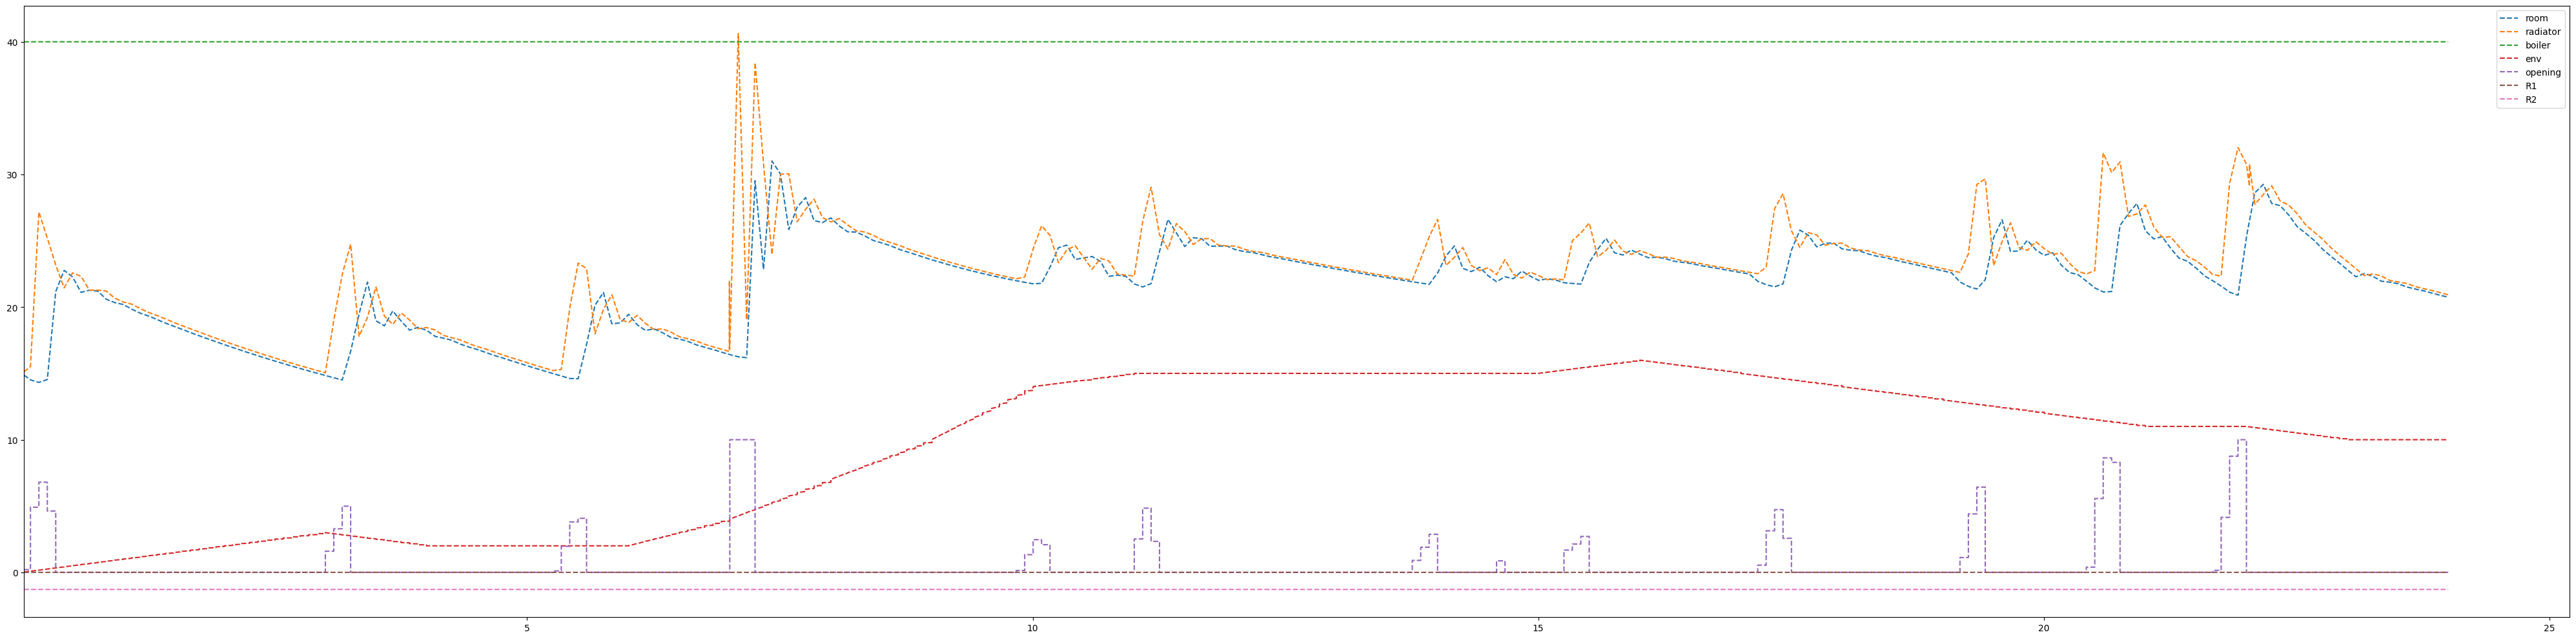

In [78]:
num = int(TimeUnits.hour) * 24
if results is not None:
    plt.figure(figsize=(40, 10))
    plt.plot(results['t']/3600, results['room'], '--', label='room')
    plt.plot(results['t']/3600, results['radiator'], '--', label='radiator')
    plt.plot(results['t']/3600, results['boiler'], '--', label='boiler')
    plt.plot(results['t']/3600, results['env'], '--', label='env')
    plt.plot(results['t']/3600, np.array(results['opening']) * 10, '--', label='opening')
    plt.plot(results['t']/3600, np.array(results['R1']) * 10000, '--', label='R1')
    plt.plot(results['t']/3600, np.array(results['R2']) * 1000, '--', label='R2')
    plt.xlim(0.025)
    # plot_event(event=cw_ow_events[0], color='r', obj=plt
    # plot_event(event=cw_ow_events[5], color='b', obj=plt)
    # plot_event(event=wake_up, color='g', obj=plt)
    # plot_event(event=time_to_sleep, color='g', obj=plt)
    #plot_event(time_to_sleep, color='r', obj=_)
    #plot_event(per_5_hour, color='g', obj=_)
    # plot_event(close_window, color='y', obj=_)
    plt.legend()        # plot_event(wake_up, color='b', obj=_)

    """for e in cw_ow_events:
        if 'open' in e.name:
            plot_event(event=e, color='b', obj=plt)
        else:
            plot_event(event=e, color='r', obj=plt)"""

    plt.tight_layout()
    plt.show()

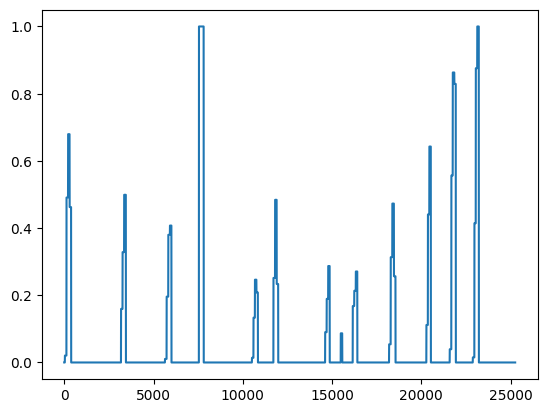

In [87]:
plt.plot(results['opening'])

In [79]:
import pandas as pd

In [80]:
tmp = pd.DataFrame([*zip(results['room'], results['env'], results['radiator'], results['boiler'])],
                   columns=['room', 'env', 'radiator', 'boiler'])
tmp.head(200)

,room,env,radiator,boiler
0,15.000000,3.000000,15.000000,40.0
1,14.993564,2.999997,15.000000,40.0
2,14.987128,2.999993,15.000000,40.0
3,14.980692,2.999990,15.000000,40.0
4,14.980435,2.999989,15.000000,40.0
...,...,...,...,...
195,14.320531,0.167908,27.170468,40.0
196,14.320530,0.167908,27.170531,40.0
197,14.320529,0.167909,27.170543,40.0
198,14.320529,0.167909,27.170545,40.0


### Gnuplot

In [83]:
data = [
    *zip(
        results['t']/3600,
        results['room'],
        results['env'],
        results['radiator'],
        results['boiler'],
        results['opening']*100,
        results['R1']*100,
        results['R2']*100,
    )
]
with open('tmp.dat', 'w') as f:
    for _ in data:
        f.write(('{} '*len(_)).format(*_))
        f.write('\n')

In [84]:
!gnuplot script.gp